In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class exp_sarsa_agent(object):
    def __init__(self, obs_n = 16, act_n = 4, learning_rate=0.3, gamma=0.98, e_greed=0.1):
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = e_greed
        self.act_n = act_n
        self.Q = np.zeros((obs_n, act_n))
        self.pi = np.ones((obs_n, act_n)) * (1 / act_n)
        self.lr_min = 1e-5

    def predict(self, S):
        Q_values = self.Q[S]
        maxQ = np.max(self.Q[S])

        action = np.random.choice(np.where(Q_values == maxQ)[0])
        return action

    def policy(self, S):
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            action = self.predict(S)
        else:
            action = np.random.choice(self.act_n)

        return action

    def learn(self, S, action, reward, S_prime, action_prime, done):
        self.Q[S, action] += self.lr * (reward + self.gamma * np.sum(self.pi[S_prime, :] * self.Q[S_prime, :]) - self.Q[S, action])
        max_action = self.predict(S)

        self.pi[S, max_action] = 1- self.epsilon
        for i in range (0, 4):
            if (i != max_action):
                self.pi[S, i] = self.epsilon / 4

    def decay(self, epsilon_decay_rate, lr_decay_rate):
        self.epsilon *= (1 - epsilon_decay_rate)
        self.lr = max(self.lr_min, self.lr * (1 - lr_decay_rate))

    def get_pi(self):
        return self.pi


In [4]:
def run_episode_es(env, agent):
    S = env.reset()
    action = agent.policy(S)
    total_reward = 0

    while (True):
        S_prime, reward, done, _ = env.step(action)

        action_prime = agent.policy(S_prime)
        agent.learn(S, action, reward, S_prime, action_prime, done)

        action = action_prime
        S = S_prime
        total_reward += reward

        if done:
            break
    
    agent.decay(epsilon_decay_rate=5e-3, lr_decay_rate=5e-4)
    
    return total_reward

def run_episode_es_reward_change(env, agent):
    S = env.reset()
    action = agent.policy(S)
    hole_location = [5, 7, 11, 12]
    goal_location = [15]

    total_reward = 0
    total_modefied_reward = 0
    while (True):
        S_prime, reward, done, _ = env.step(action)
        modefied_reward = 0
        if (S_prime in hole_location):
            modefied_reward = -100
        elif (S_prime in goal_location):
            modefied_reward = 100
        else:
            modefied_reward = 0

        action_prime = agent.policy(S_prime)
        agent.learn(S, action, modefied_reward, S_prime, action_prime, done)

        action = action_prime
        S = S_prime
        total_reward += reward
        total_modefied_reward += modefied_reward

        if done:
            break
    
    agent.decay(epsilon_decay_rate=5e-3, lr_decay_rate=5e-4)
    
    return total_reward, total_modefied_reward

In [5]:
def run_frozen_lake():
    env = gym.make("FrozenLake-v0")
    history_unchanged = []
    history_changed = []
    
    for run in range(10):
        es_agent_1 = exp_sarsa_agent(obs_n=env.observation_space.n,  act_n=env.action_space.n, 
        learning_rate=0.3, gamma = 0.98, e_greed=0.9)

        es_agent_2 = exp_sarsa_agent(obs_n=env.observation_space.n,  act_n=env.action_space.n, 
        learning_rate=0.3, gamma = 0.98, e_greed=0.9)

        es_reward_list = np.zeros(5000)
        es_changed_reward_list = np.zeros(5000)
        
        for i in range(5000):
            es_reward = run_episode_es(env, es_agent_1)
            es_changed_reward, _ = run_episode_es_reward_change(env, es_agent_2)
            es_reward_list[i] = es_reward
            es_changed_reward_list[i] = es_changed_reward

        history_unchanged.append(es_reward_list)
        history_changed.append(es_changed_reward_list)
    
    return history_unchanged, history_changed

In [6]:
history_unchanged, history_changed = run_frozen_lake()

In [12]:
def avg_reward(reward_list):
    unchanged = reward_list.reshape(10, 5000)
    unchanged = np.mean(unchanged, axis=0)

    reward_history = []
    for i in range(50):
        reward_history.append(np.mean(unchanged[:i+1]))
    for i in range(50, 5000):
        reward_history.append(np.mean(unchanged[i - 50:i]))

    return range(0, 5000), reward_history

Text(0.5, 1.0, 'Avergae reward using smoothed method')

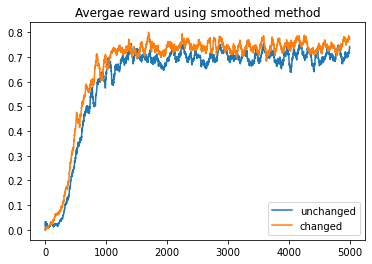

In [15]:
unchanged = np.array(history_unchanged)
changed = np.array(history_changed)

x_org, y_org = avg_reward(unchanged)
x_mod, y_mod = avg_reward(changed)
plt.plot(x_org, y_org)
plt.plot(x_mod, y_mod)
plt.legend(["unchanged", "changed"])
plt.title("Avergae reward using smoothed method")

Text(0.5, 1.0, 'Avergae reward using smoothed method')

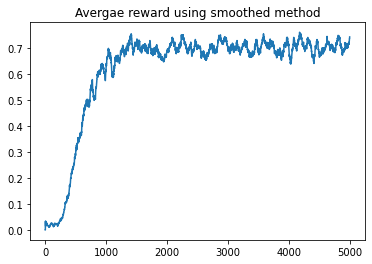

In [16]:
plt.plot(x_org, y_org)
plt.title("Avergae reward using smoothed method")